In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
from glob import glob
import os
from astropy.io import fits

pscale = 45 # mas/pixel, according to Yinuo's email

In [2]:
# directory = "Data\\JWST\\MAST_2024-07-29T2157\\JWST"
# # fname = glob(directory+"\\jw05842001001_03101_00001_mirimage\\*_cal.fits")[0]
# fname = glob(directory+"\\jw05842-o001_t001_miri_f2550w\\*_i2d.fits")[0]

# fname

directory = "Data\\VLT"
fnames = glob(directory + "\\*.fits")

vlt_years = [2016, 2017, 2018, 2024]
vlt_data = {}
colours = {2016:"tab:blue", 2017:"tab:green", 2018:"tab:red", 2024:"tab:purple"}

for i, fname in enumerate(fnames):
    vlt_data[vlt_years[i]] = fits.open(fname)

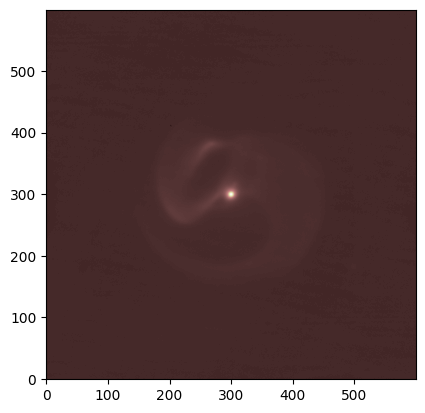

In [3]:
fig, ax = plt.subplots()
ax.imshow(vlt_data[2024][0].data, cmap='pink')
ax.invert_yaxis()

600


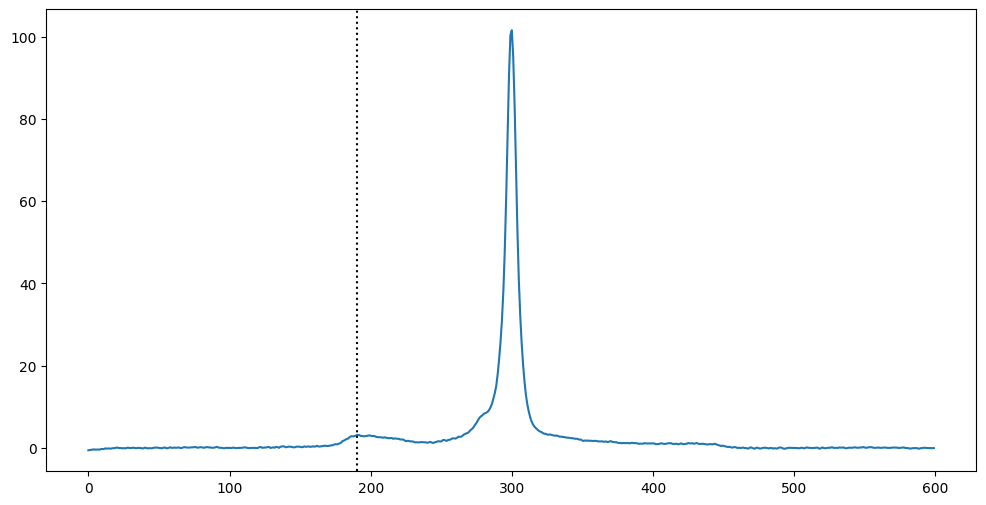

In [4]:
brightnesses = vlt_data[2024][0].data[::-1, 300]
brightnesses = vlt_data[2024][0].data[300, :]
print(len(brightnesses))
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(brightnesses)
ax.axvline(190, ls=':', c='k')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

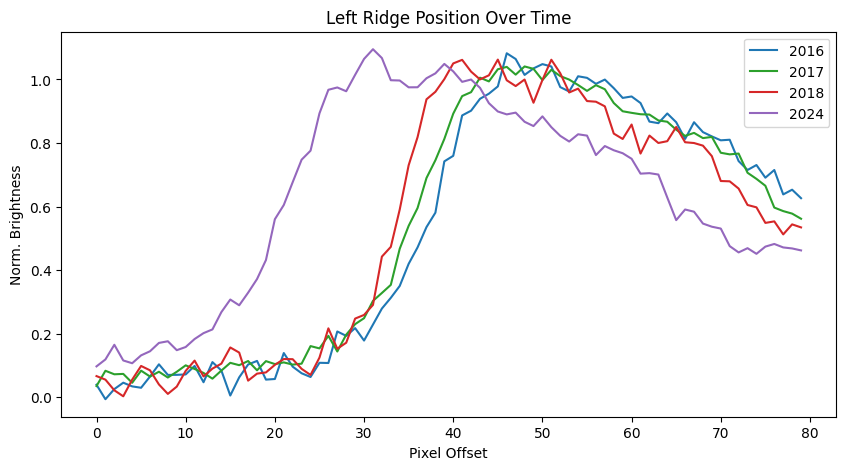

In [6]:
left_ridges = {}

fig, ax = plt.subplots(figsize=(10, 5))
for key in vlt_data.keys():
    epoch_data = vlt_data[key][0].data[300, 160:240]
    denumerator = np.percentile(epoch_data, 90) # don't want to just divide by the maximum, but the rough maximum
    left_ridges[key] = epoch_data / denumerator
    left_ridges['x'] = np.arange(len(epoch_data))
    ax.plot(left_ridges[key], label=str(key), c=colours[key])
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

[Text(0.5, 1.0, 'Left Ridge Position Over Time'),
 Text(0.5, 0, 'Pixel Offset'),
 Text(0, 0.5, 'Norm. Brightness')]

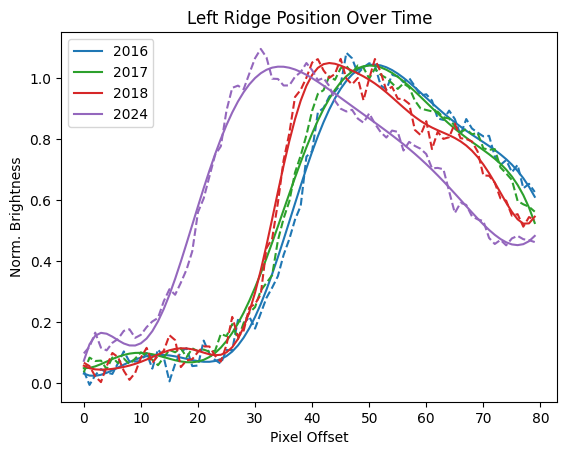

In [8]:
from scipy.interpolate import UnivariateSpline

left_ridge_splines = {}
fig, ax = plt.subplots()

for key in vlt_data.keys():
    left_ridge_splines[key] = UnivariateSpline(left_ridges['x'], left_ridges[key], k=5, s=0.1, ext=3)
    ax.plot(left_ridges['x'], left_ridge_splines[key](left_ridges['x']), c=colours[key], label=str(key))
    ax.plot(left_ridges['x'], left_ridges[key], c=colours[key], ls='--')
    
ax.legend()
ax.set(title='Left Ridge Position Over Time', xlabel='Pixel Offset', ylabel='Norm. Brightness')

In [9]:
from scipy.optimize import least_squares

use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

# def residual_error_squared(a, x, y):
#     shifted_x = x - a
#     if shifted_x < min_val or shifted_x > max_val:
#         return 0
#     error = use_left_ridge_spline(shifed_x) - y
#     return error

def residual_error_squared(a, x, y):
    shifted_x = x - a
    residuals = np.zeros(len(x))
    for i in range(len(x)):
        if shifted_x[i] < min_val or shifted_x[i] > max_val:
            residuals[i] = np.nan
        else:
            residuals[i] = use_left_ridge_spline(shifted_x[i]) - y[i]
    mask = ~np.isnan(residuals)
    return residuals[mask]

test_data = left_ridges[2024]

result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
test_shift = result.x
# [test_shift], _ = curve_fit(shift_edge, ydata=test_data, xdata=left_ridges['x'], p0=(30))
print(test_shift)
fig, ax = plt.subplots()
ax.plot(left_ridges['x'], test_data)
ax.plot(left_ridges['x'], shift_edge(left_ridges['x'], test_shift))

ValueError: operands could not be broadcast together with shapes (49,) (50,) 

-16.39369832288724


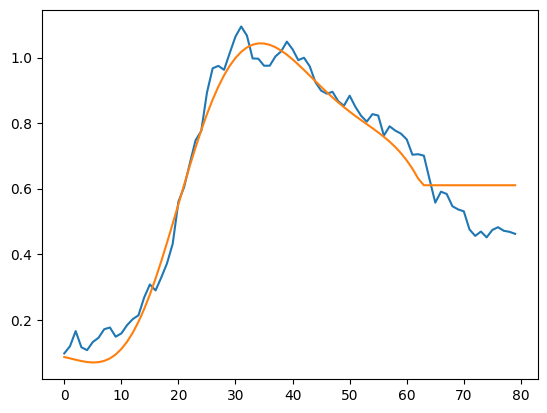

In [13]:
from scipy.optimize import least_squares, curve_fit


use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
#     if x - a < min_val or x - a > max_val:
#         return np.nan
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

test_data = left_ridges[2024]

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
[test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
print(test_shift)
fig, ax = plt.subplots()
ax.plot(left_ridges['x'], test_data)
ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))

[  0.          -1.60513112  -3.67255127 -16.39369832]


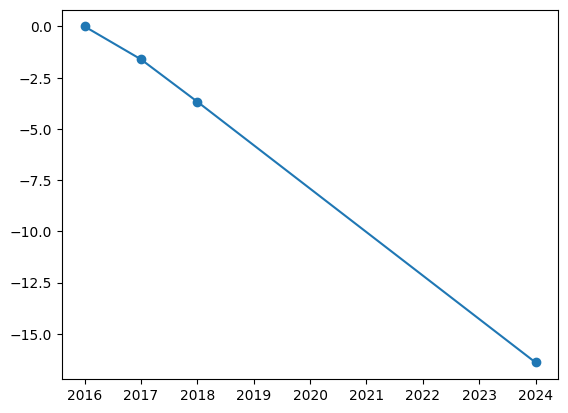

In [14]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    [shift], _ = curve_fit(shifted_spline, ydata=left_ridges[year], xdata=left_ridges['x'], p0=(-10))
    left_ridge_shifts[i+1] = shift
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 91.37 mas/yr
Hence the windspeed from the left edge is 1040.3 km/s


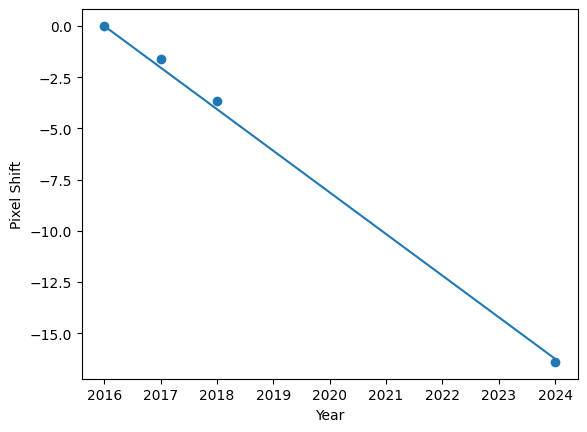

In [15]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")

# Try again but with a more sophisticated fitting procedure
The previous way included the spline even when out of bounds of the original data. This new way doesn't try to solve the least squares in that regime.

[-1.5464745]


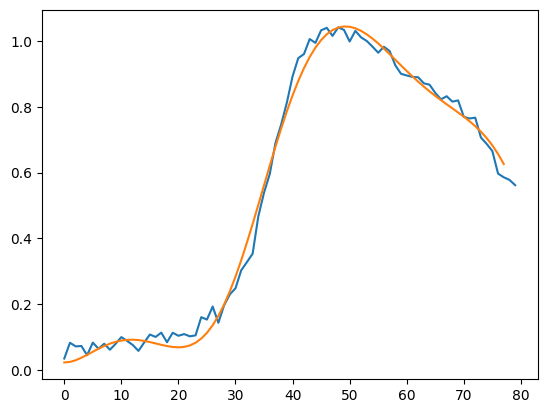

In [98]:
from scipy.optimize import least_squares, curve_fit, minimize


use_left_ridge_spline = left_ridge_splines[2016]
min_x, max_x = min(left_ridges['x']), max(left_ridges['x'])

def chi_sq_err(shift, y, x):
    shifted_x = x - shift
#     use_args = np.argwhere((shifted_x >= min_x) & (x <= max_x - shift)).flatten()
    use_args = np.argwhere((shifted_x >= min_x) & (shifted_x <= min(max_val, max_val + shift))).flatten()
    use_x = x[use_args]
    use_y = y[use_args]
    residuals = use_y - use_left_ridge_spline(shifted_x[use_args])
    return np.sum(residuals**2) / (len(use_x) - 1)


test_data = left_ridges[2017]

# # result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
# [test_shift], _ = curve_fit(shifted_spline, ydata=test_data, xdata=left_ridges['x'], p0=(-10))
# print(test_shift)
# fig, ax = plt.subplots()
# ax.plot(left_ridges['x'], test_data)
# ax.plot(left_ridges['x'], shifted_spline(left_ridges['x'], test_shift))
result = minimize(chi_sq_err, -5, args=(test_data, left_ridges['x']), method='Powell')
test_shift = result.x
print(test_shift)
shifted_x = left_ridges['x'] - test_shift
use_args = np.argwhere((shifted_x >= min_x) & (left_ridges['x'] <= min(max_val, max_val+test_shift))).flatten()

fig, ax = plt.subplots()
ax.plot(left_ridges['x'], test_data)
ax.plot(left_ridges['x'][use_args], use_left_ridge_spline(shifted_x[use_args]))


[  0.          -1.54647521  -3.49999945 -16.63204596]


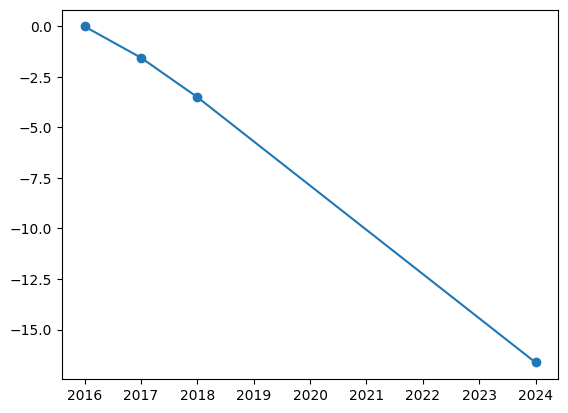

In [100]:
use_left_ridge_spline = left_ridge_splines[2016]
min_val, max_val = min(left_ridges['x']), max(left_ridges['x'])

def shifted_spline_sub(x, a):
    return use_left_ridge_spline(x - a)
def shifted_spline(x, a):
    vals = np.zeros(len(x))
    for i in range(len(x)):
        vals[i] = shifted_spline_sub(x[i], a)
    return vals

# result = least_squares(residual_error_squared, [30], args=(left_ridges['x'], test_data))
epochs = np.array(vlt_years)
left_ridge_shifts = np.zeros(len(epochs))
for i, year in enumerate(vlt_years[1:]):
    result = minimize(chi_sq_err, -10, args=(left_ridges[year], left_ridges['x']), method='Powell')
    left_ridge_shifts[i+1] = result.x[0]
    
print(left_ridge_shifts)
fig, ax = plt.subplots()
ax.plot(epochs, left_ridge_shifts, marker='o')

Expansion of left ridge is 92.35 mas/yr
Hence the windspeed from the left edge is 1051.5 km/s


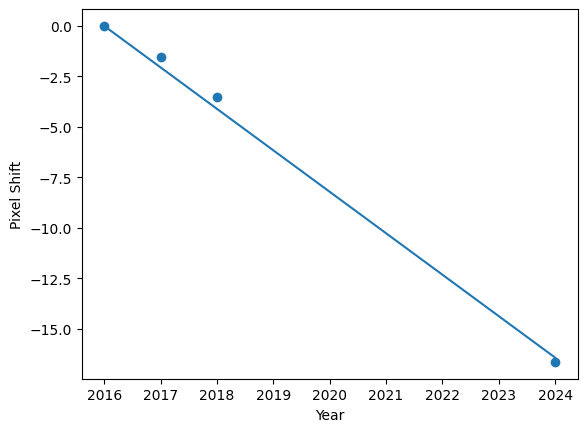

In [101]:
xmin = 2016
def linear_eq(x, m):
    '''By definition we need the shift to be 0 at 2016, and so we have no y-intercept parameter'''
    return m * (x - xmin)

[m], _ = curve_fit(linear_eq, ydata=left_ridge_shifts, xdata=epochs, p0=(-1.8))

fig, ax = plt.subplots()
ax.scatter(epochs, left_ridge_shifts)
ax.plot(epochs, linear_eq(epochs, m))
ax.set(xlabel='Year', ylabel='Pixel Shift')

left_ridge_expansion = abs(m)*pscale # mas/yr

apep_dist = 2.4 # kpc
yr2s = 365 * 24 * 60 * 60
kpc2km = 3.086e16
left_ridge_windspeed = np.tan(np.deg2rad(left_ridge_expansion / (1e3*60*60))) * apep_dist*kpc2km / yr2s

print(f"Expansion of left ridge is {left_ridge_expansion:.2f} mas/yr")
print(f"Hence the windspeed from the left edge is {left_ridge_windspeed:.1f} km/s")